In [6]:
#1
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))
from NeuralNet import NeuralNet

In [7]:
#2
fuelCon = pd.read_csv("../data/FuelConsumptionCo2.csv")


print("FuelCon shape:", fuelCon.shape)


FuelCon shape: (1067, 13)


In [8]:
#3
print(fuelCon.head())


   MODELYEAR   MAKE       MODEL VEHICLECLASS  ENGINESIZE  CYLINDERS  \
0       2014  ACURA         ILX      COMPACT         2.0          4   
1       2014  ACURA         ILX      COMPACT         2.4          4   
2       2014  ACURA  ILX HYBRID      COMPACT         1.5          4   
3       2014  ACURA     MDX 4WD  SUV - SMALL         3.5          6   
4       2014  ACURA     RDX AWD  SUV - SMALL         3.5          6   

  TRANSMISSION FUELTYPE  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  \
0          AS5        Z                   9.9                  6.7   
1           M6        Z                  11.2                  7.7   
2          AV7        Z                   6.0                  5.8   
3          AS6        Z                  12.7                  9.1   
4          AS6        Z                  12.1                  8.7   

   FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  CO2EMISSIONS  
0                   8.5                        33           196  
1                   

In [9]:
#4
cat_cols = ['MAKE', 'MODEL', 'VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE']
num_cols = [
    'MODELYEAR', 'ENGINESIZE', 'CYLINDERS',
    'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY',
    'FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_COMB_MPG'
]




In [10]:
#3a
print("Missing values por columna:")
print(fuelCon.isna().sum())

Missing values por columna:
MODELYEAR                   0
MAKE                        0
MODEL                       0
VEHICLECLASS                0
ENGINESIZE                  0
CYLINDERS                   0
TRANSMISSION                0
FUELTYPE                    0
FUELCONSUMPTION_CITY        0
FUELCONSUMPTION_HWY         0
FUELCONSUMPTION_COMB        0
FUELCONSUMPTION_COMB_MPG    0
CO2EMISSIONS                0
dtype: int64


In [11]:
#3b
print(fuelCon[num_cols + ['CO2EMISSIONS']].describe())

       MODELYEAR   ENGINESIZE    CYLINDERS  FUELCONSUMPTION_CITY  \
count     1067.0  1067.000000  1067.000000           1067.000000   
mean      2014.0     3.346298     5.794752             13.296532   
std          0.0     1.415895     1.797447              4.101253   
min       2014.0     1.000000     3.000000              4.600000   
25%       2014.0     2.000000     4.000000             10.250000   
50%       2014.0     3.400000     6.000000             12.600000   
75%       2014.0     4.300000     8.000000             15.550000   
max       2014.0     8.400000    12.000000             30.200000   

       FUELCONSUMPTION_HWY  FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  \
count          1067.000000           1067.000000               1067.000000   
mean              9.474602             11.580881                 26.441425   
std               2.794510              3.485595                  7.468702   
min               4.900000              4.700000                 11.000000 

In [12]:
#5
y = fuelCon['CO2EMISSIONS'].values.astype(float).reshape(-1, 1)


In [13]:
#6
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

X = preprocessor.fit_transform(fuelCon)


In [14]:
#7
if hasattr(X, "toarray"):
    X = X.toarray()


In [15]:
#8
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train+Val shape:", X_trainval.shape, y_trainval.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Normalización de y basada SOLO en train+val
y_mean = y_trainval.mean()
y_std = y_trainval.std()

y_trainval_norm = (y_trainval - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std

Train+Val shape: (853, 751) (853, 1)
Test shape: (214, 751) (214, 1)


In [16]:
#9
input_size = X_trainval.shape[1]

nn = NeuralNet(
    n_layers=3,
    n_units=[input_size, 20, 1],
    epochs=50,
    lr=0.001,
    momentum=0.8,
    activation='sigmoid',
    val_percent=0.2
)

# Entrenar SOLO con train+val normalizado
nn.fit(X_trainval, y_trainval_norm)

# Predicciones en el conjunto de TEST 
y_pred_norm_test = nn.predict(X_test)
y_pred_test = y_pred_norm_test * y_std + y_mean

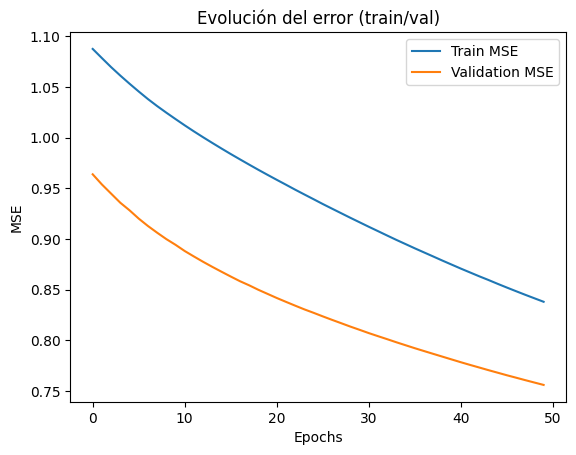

Último error (train, val): [0.83792235 0.75584919]


In [17]:
#10
loss = nn.loss_epochs()
plt.plot(loss[:,0], label='Train MSE')
plt.plot(loss[:,1], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Evolución del error (train/val)')
plt.legend()
plt.show()

print("Último error (train, val):", loss[-1])


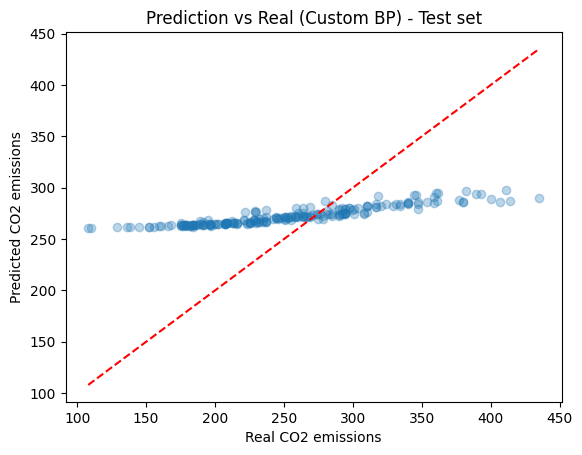

In [18]:
#11
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real CO2 emissions')
plt.ylabel('Predicted CO2 emissions')
plt.title('Prediction vs Real (Custom BP) - Test set')
plt.show()

In [19]:
#12
param_grid = [
    {"layers": 3, "units": [input_size, 10, 1], "lr": 0.01, "momentum": 0.5, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 20, 1], "lr": 0.01, "momentum": 0.9, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 30, 1], "lr": 0.005, "momentum": 0.8, "act": "tanh"},
    {"layers": 3, "units": [input_size, 50, 1], "lr": 0.001, "momentum": 0.9, "act": "relu"},
    {"layers": 4, "units": [input_size, 32, 16, 1], "lr": 0.01, "momentum": 0.7, "act": "sigmoid"},
    {"layers": 4, "units": [input_size, 64, 32, 1], "lr": 0.005, "momentum": 0.8, "act": "tanh"},
    {"layers": 3, "units": [input_size, 16, 1], "lr": 0.02, "momentum": 0.5, "act": "sigmoid"},
    {"layers": 3, "units": [input_size, 40, 1], "lr": 0.002, "momentum": 0.9, "act": "tanh"},
    {"layers": 3, "units": [input_size, 25, 1], "lr": 0.01, "momentum": 0.9, "act": "relu"},
    {"layers": 4, "units": [input_size, 32, 16, 1], "lr": 0.001, "momentum": 0.8, "act": "linear"}
]



In [ ]:
#13
results = []
best_mse = float('inf')
best_preds = None
best_params = None
best_loss_curve = None

for i, params in enumerate(param_grid):
    print(f"\nTraining model {i+1}/{len(param_grid)} with params: {params}")

    nn = NeuralNet(
        n_layers=params["layers"],
        n_units=params["units"],
        epochs=50,
        lr=params["lr"],
        momentum=params["momentum"],
        activation=params["act"],
        val_percent=0.2
    )

    # Entrenamos con train+val normalizado
    nn.fit(X_trainval, y_trainval_norm)
    loss_curve = nn.loss_epochs()

    # Predicción en el conjunto de test
    y_pred_norm_test = nn.predict(X_test)
    y_pred_test = y_pred_norm_test * y_std + y_mean  # desnormalizar

    # Métricas en test (y_test está en escala original)
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    y_true = y_test.reshape(-1)
    y_pred = y_pred_test.reshape(-1)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    results.append({
        "Layers": params["layers"],
        "Structure": str(params["units"]),
        "LR": params["lr"],
        "Momentum": params["momentum"],
        "Act": params["act"],
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "Loss": loss_curve
    })

    if mse < best_mse:
        best_mse = mse
        best_preds = y_pred_test
        best_params = params
        best_loss_curve = loss_curve

    print(f" → MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")



Training model 1/10 with params: {'layers': 3, 'units': [751, 10, 1], 'lr': 0.01, 'momentum': 0.5, 'act': 'sigmoid'}
 → MSE: 2987.24, MAE: 44.17, MAPE: 26.86%

Training model 2/10 with params: {'layers': 3, 'units': [751, 20, 1], 'lr': 0.01, 'momentum': 0.9, 'act': 'sigmoid'}
 → MSE: 2674.75, MAE: 40.42, MAPE: 27.43%

Training model 3/10 with params: {'layers': 3, 'units': [751, 30, 1], 'lr': 0.005, 'momentum': 0.8, 'act': 'tanh'}
 → MSE: 775.74, MAE: 18.53, MAPE: 27.21%

Training model 4/10 with params: {'layers': 3, 'units': [751, 50, 1], 'lr': 0.001, 'momentum': 0.9, 'act': 'relu'}
 → MSE: 2184.92, MAE: 34.23, MAPE: 29.33%

Training model 5/10 with params: {'layers': 4, 'units': [751, 32, 16, 1], 'lr': 0.01, 'momentum': 0.7, 'act': 'sigmoid'}
 → MSE: 3789.55, MAE: 50.92, MAPE: 25.37%

Training model 6/10 with params: {'layers': 4, 'units': [751, 64, 32, 1], 'lr': 0.005, 'momentum': 0.8, 'act': 'tanh'}
 → MSE: 688.87, MAE: 16.76, MAPE: 27.04%

Training model 7/10 with params: {'laye

In [22]:
#14
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("MSE").reset_index(drop=True)
df_results


,Layers,Structure,LR,Momentum,Act,MSE,MAE,MAPE,Loss
0,4,"[751, 32, 16, 1]",0.001,0.8,linear,139.062923,9.125689,30.814676,"[[0.4343094492398732, 0.13872329783575266], [0..."
1,4,"[751, 64, 32, 1]",0.005,0.8,tanh,688.866908,16.755671,27.044626,"[[0.34854424178148247, 0.23389240028810637], [..."
2,3,"[751, 30, 1]",0.005,0.8,tanh,775.740080,18.525566,27.206127,"[[0.4189278593094549, 0.2268272759854447], [0...."
3,3,"[751, 40, 1]",0.002,0.9,tanh,841.812661,18.962422,27.638232,"[[0.5830553261844889, 0.20714744149278377], [0..."
4,3,"[751, 25, 1]",0.010,0.9,relu,2096.946845,31.209610,29.599138,"[[0.6098498816705676, 0.6161477351783384], [0...."
5,3,"[751, 50, 1]",0.001,0.9,relu,2184.917825,34.228491,29.331594,"[[1.0191556084958033, 0.920014053260326], [1.0..."
6,3,"[751, 20, 1]",0.010,0.9,sigmoid,2674.746560,40.415475,27.426986,"[[1.3129707347767068, 1.087465657355988], [0.9..."
7,3,"[751, 16, 1]",0.020,0.5,sigmoid,2769.479687,41.700569,27.305953,"[[1.157074227206218, 1.2177492952895999], [1.0..."
8,3,"[751, 10, 1]",0.010,0.5,sigmoid,2987.242199,44.167674,26.863808,"[[1.317950611835091, 1.2539696051058042], [1.2..."
9,4,"[751, 32, 16, 1]",0.010,0.7,sigmoid,3789.548056,50.920277,25.369923,"[[1.1453272812821655, 1.1017850846859145], [1...."


In [23]:
#15
best_idx = df_results["MSE"].idxmin()
best_model = df_results.iloc[best_idx]
best_model


Layers                                                       4
Structure                                     [751, 32, 16, 1]
LR                                                       0.001
Momentum                                                   0.8
Act                                                     linear
MSE                                                 139.062923
MAE                                                   9.125689
MAPE                                                 30.814676
Loss         [[0.4343094492398732, 0.13872329783575266], [0...
Name: 0, dtype: object

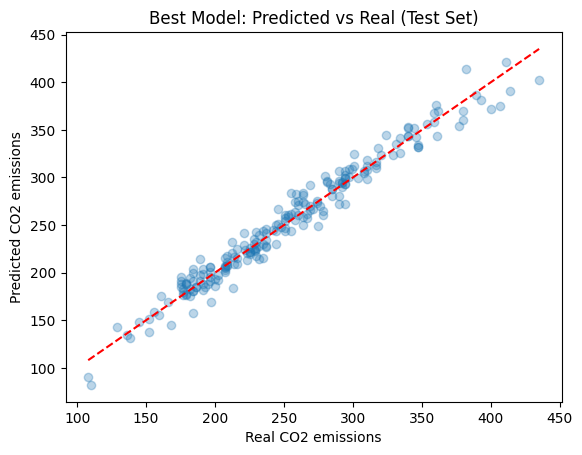

In [25]:
#16
plt.scatter(y_test, best_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real CO2 emissions")
plt.ylabel("Predicted CO2 emissions")
plt.title("Best Model: Predicted vs Real (Test Set)")
plt.show()


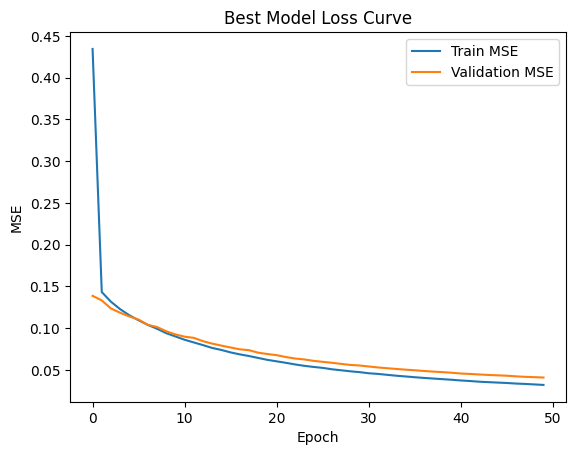

In [26]:
#17
loss = best_loss_curve
plt.plot(loss[:,0], label='Train MSE')
plt.plot(loss[:,1], label='Validation MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Best Model Loss Curve")
plt.show()


In [27]:
#18
print("y first 10 values:\n", y[:10])
print("y shape:", y.shape)
print("min:", y.min(), "max:", y.max())
print("mean:", y.mean(), "std:", y.std())


y first 10 values:
 [[196.]
 [221.]
 [136.]
 [255.]
 [244.]
 [230.]
 [232.]
 [255.]
 [267.]
 [212.]]
y shape: (1067, 1)
min: 108.0 max: 488.0
mean: 256.2286785379569 std: 63.34260099404252


In [ ]:
#19 - MLR-F (Regresión Lineal)
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(X_trainval, y_trainval)   # y en escala original

y_mlr_pred = mlr.predict(X_test)

mlr_mse = mean_squared_error(y_test, y_mlr_pred)
mlr_mae = mean_absolute_error(y_test, y_mlr_pred)
y_true = y_test.reshape(-1)
y_mlr = y_mlr_pred.reshape(-1)
mlr_mape = np.mean(np.abs((y_true - y_mlr) / y_true)) * 100

print("MLR-F Results:")
print("  MSE :", mlr_mse)
print("  MAE :", mlr_mae)
print("  MAPE:", mlr_mape)


MLR-F Results:
  MSE : 106.27413169533642
  MAE : 5.606606377727261
  MAPE: 2.81270916568443


In [ ]:
#20 - BP-F (MLPRegressor)
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)

mlp.fit(X_trainval, y_trainval.reshape(-1))  # debe ser 1D

y_mlp_pred = mlp.predict(X_test)

mlp_mse = mean_squared_error(y_test, y_mlp_pred)
mlp_mae = mean_absolute_error(y_test, y_mlp_pred)
y_true = y_test.reshape(-1)
y_mlp = y_mlp_pred.reshape(-1)
mlp_mape = np.mean(np.abs((y_true - y_mlp) / y_true)) * 100


print("BP-F Results:")
print("  MSE :", mlp_mse)
print("  MAE :", mlp_mae)
print("  MAPE:", mlp_mape)


BP-F Results:
  MSE : 208.46706400731546
  MAE : 11.011774923506092
  MAPE: 29.751360074566215


C:\Users\xavie\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#21 - Tabla comparativa correcta
comparison = pd.DataFrame({
    "Model": ["Custom BP (best)", "MLR-F", "BP-F"],
    "MSE":  [best_mse, mlr_mse, mlp_mse],
    "MAE":  [best_model["MAE"], mlr_mae, mlp_mae],
    "MAPE": [best_model["MAPE"], mlr_mape, mlp_mape]
})

comparison

,Model,MSE,MAE,MAPE
0,Custom BP (best),139.062923,9.125689,30.814676
1,MLR-F,106.274132,5.606606,2.812709
2,BP-F,208.467064,11.011775,29.751360


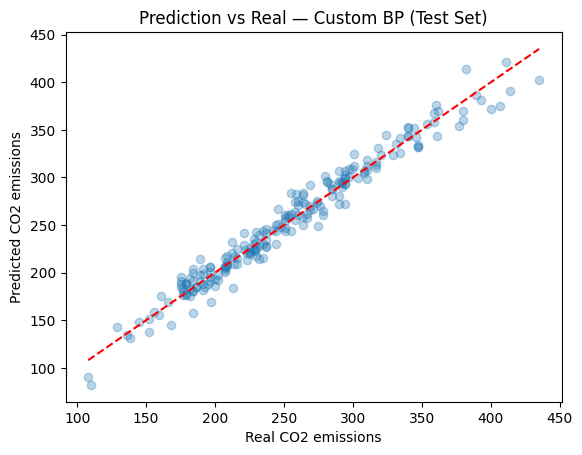

In [31]:
#22a - Custom BP
plt.scatter(y_test, best_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real CO2 emissions")
plt.ylabel("Predicted CO2 emissions")
plt.title("Prediction vs Real — Custom BP (Test Set)")
plt.show()


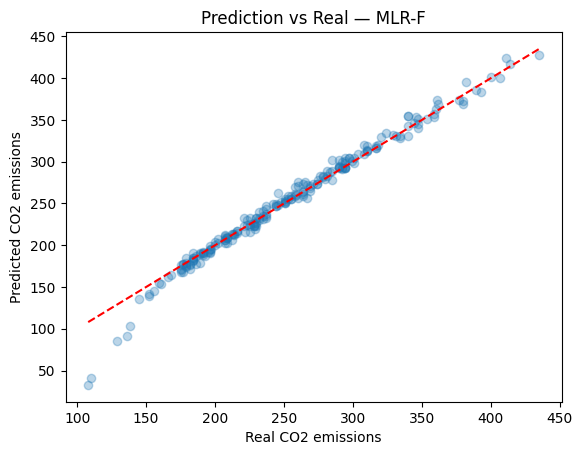

In [32]:
#22b - MLR-F
plt.scatter(y_test, y_mlr_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real CO2 emissions")
plt.ylabel("Predicted CO2 emissions")
plt.title("Prediction vs Real — MLR-F")
plt.show()


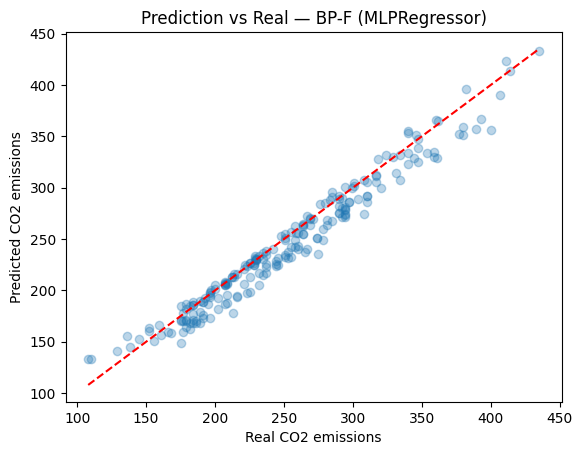

In [33]:
#22c - BP-F
plt.scatter(y_test, y_mlp_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Real CO2 emissions")
plt.ylabel("Predicted CO2 emissions")
plt.title("Prediction vs Real — BP-F (MLPRegressor)")
plt.show()
